<a href="https://colab.research.google.com/github/margazadasha/Computer-data-vizualization-systems/blob/main/%D0%9A%D0%A1%D0%92%D0%94_%D0%9B%D0%A0_7_%D0%9C%D0%B0%D1%80%D0%B3%D0%B0%D0%B7%D0%B0_4_6_%D0%A4%D0%86%D0%A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Лабораторна робота №7**

**Тема:** Побудова автокодувальника з шумом для датасету рукописних цифр із застосуваням бібліотеки PyTorch.

**Завдання.** Побудувати автокодувальник з шумом для детекції зображень з датасету рукописних цифр із застосуваням бібліотеки PyTorch.

In [14]:
import os
import random
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import torchvision
import torch
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

In [15]:
# Завантаження даних з датасету рукописних цифр MNIST
data_dir = 'data'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

print(train_dataset)
type(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train


torchvision.datasets.mnist.MNIST

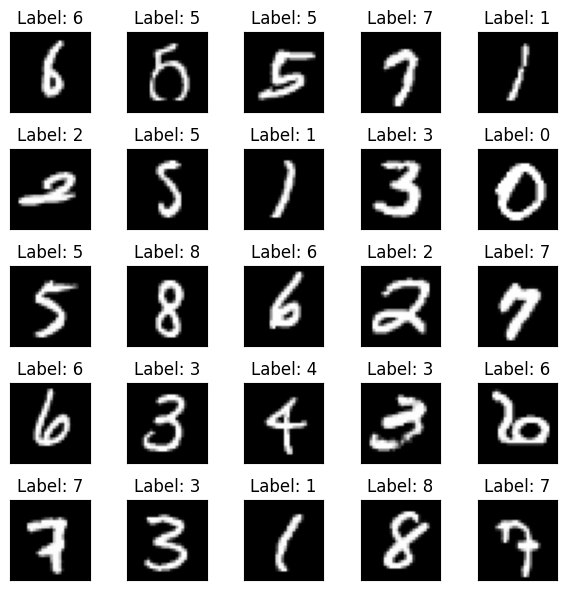

In [16]:
# Виведення зображень
fig, axs = plt.subplots(5, 5, figsize=(6,6))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [17]:
# Додавання фцнкції шуму до зображень
def add_gaussian_noise(inputs, noise_factor=0.3):
    noisy = inputs + noise_factor * torch.randn_like(inputs)
    return torch.clamp(noisy, 0., 1.)

In [18]:
# Перетворення даних в тензори
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset.transform = train_transform

test_dataset.transform = test_transform

In [19]:
m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(len(train_dataset)*0.8), int(m*0.2)])

In [20]:
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [21]:
# Побудова автокодувальника з шумом
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()

        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        # Шар для розправлення Flatten
        self.flatten = nn.Flatten(start_dim=1)

        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

In [22]:
# Побудова декодувальника
class Decoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim=128):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 7 * 7 * 16),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(16, 7, 7))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 4, stride=2, padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [23]:
# Встановлення випадкового початкового числа для відтворюваних результатів
torch.manual_seed(42)

# Ініціалізація обох мереж
encoded_space_dim = 4  # Розмір закодованого простору
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

In [25]:
img, _ = test_dataset[0]
img = img.unsqueeze(0)
print('Original image shape:', img.shape)

# Автокодовані зображення
img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)

# Декодовані зображення
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 4])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [26]:
# Визначення функції втрат
loss_fn = torch.nn.MSELoss()

# Визначення оптимізатора (і для автокодувальника, і для декодувальника)
lr= 0.001

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

encoder.to(device)

Selected device: cuda


Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [27]:
decoder.to(device)

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(16, 7, 7))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [28]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Встановлення тренувального режиму і для автокодувальника, і для декодувальника
    encoder.train()
    decoder.train()
    train_loss = []

    for image_batch, _ in dataloader:
        # Перенесення тензова до відповідного девайсу
        image_batch = image_batch.to(device)
        # Автокодування даних
        encoded_data = encoder(image_batch)
        # Декодування даних
        decoded_data = decoder(encoded_data)
        # Оцінка втрат
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Виведення втрати
        print('\\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Встановлення оцінювального режиму і для автокодувальника, і для декодувальника
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Перенесення тензова до відповідного девайсу
            image_batch = image_batch.to(device)
            # Автокодування даних
            encoded_data = encoder(image_batch)
            # Декодування даних
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        # Оцінка загальної втрати
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [29]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[i][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()

\t partial train loss (single batch): 0.332593
\t partial train loss (single batch): 0.321265
\t partial train loss (single batch): 0.312478
\t partial train loss (single batch): 0.306577
\t partial train loss (single batch): 0.300103
\t partial train loss (single batch): 0.294960
\t partial train loss (single batch): 0.288801
\t partial train loss (single batch): 0.285316
\t partial train loss (single batch): 0.280724
\t partial train loss (single batch): 0.276002
\t partial train loss (single batch): 0.271551
\t partial train loss (single batch): 0.268292
\t partial train loss (single batch): 0.263418
\t partial train loss (single batch): 0.260002
\t partial train loss (single batch): 0.258080
\t partial train loss (single batch): 0.254715
\t partial train loss (single batch): 0.251168
\t partial train loss (single batch): 0.248683
\t partial train loss (single batch): 0.245946
\t partial train loss (single batch): 0.243104
\t partial train loss (single batch): 0.241020
\t partial tr

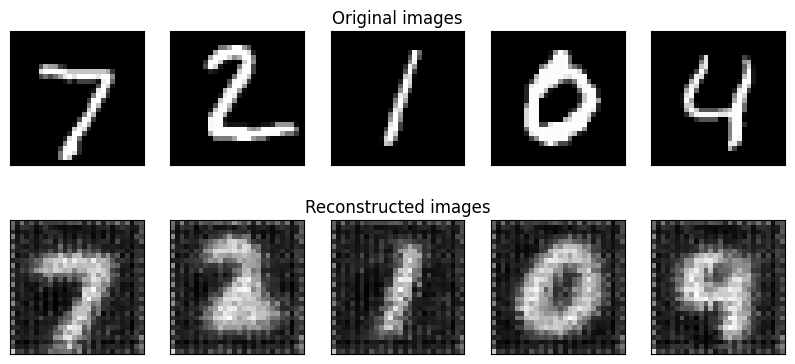

\t partial train loss (single batch): 0.061109
\t partial train loss (single batch): 0.059818
\t partial train loss (single batch): 0.059532
\t partial train loss (single batch): 0.058400
\t partial train loss (single batch): 0.059457
\t partial train loss (single batch): 0.058845
\t partial train loss (single batch): 0.059785
\t partial train loss (single batch): 0.057989
\t partial train loss (single batch): 0.058074
\t partial train loss (single batch): 0.057856
\t partial train loss (single batch): 0.057931
\t partial train loss (single batch): 0.057370
\t partial train loss (single batch): 0.058189
\t partial train loss (single batch): 0.058549
\t partial train loss (single batch): 0.055911
\t partial train loss (single batch): 0.056790
\t partial train loss (single batch): 0.056787
\t partial train loss (single batch): 0.055927
\t partial train loss (single batch): 0.056714
\t partial train loss (single batch): 0.056854
\t partial train loss (single batch): 0.055820
\t partial tr

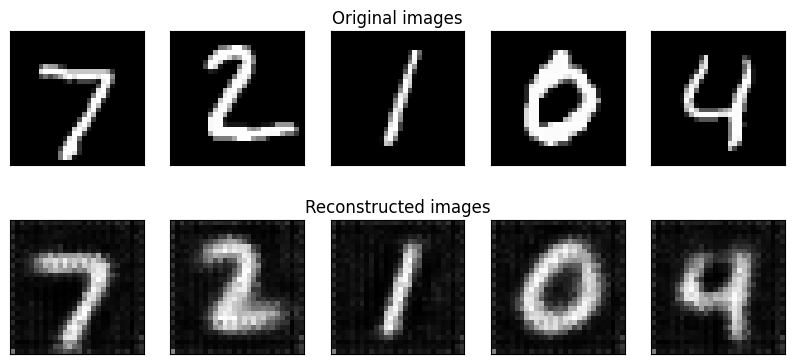

\t partial train loss (single batch): 0.041063
\t partial train loss (single batch): 0.039841
\t partial train loss (single batch): 0.038827
\t partial train loss (single batch): 0.037829
\t partial train loss (single batch): 0.040040
\t partial train loss (single batch): 0.039008
\t partial train loss (single batch): 0.040019
\t partial train loss (single batch): 0.038911
\t partial train loss (single batch): 0.039158
\t partial train loss (single batch): 0.038534
\t partial train loss (single batch): 0.038959
\t partial train loss (single batch): 0.039348
\t partial train loss (single batch): 0.040058
\t partial train loss (single batch): 0.040598
\t partial train loss (single batch): 0.037831
\t partial train loss (single batch): 0.039269
\t partial train loss (single batch): 0.039007
\t partial train loss (single batch): 0.038707
\t partial train loss (single batch): 0.039760
\t partial train loss (single batch): 0.040222
\t partial train loss (single batch): 0.038959
\t partial tr

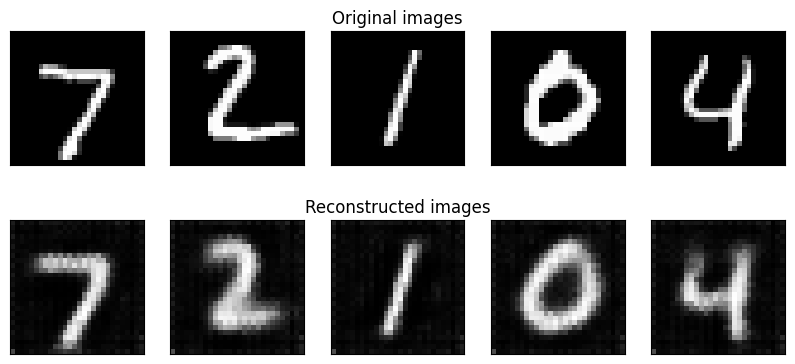

\t partial train loss (single batch): 0.036025
\t partial train loss (single batch): 0.034152
\t partial train loss (single batch): 0.033182
\t partial train loss (single batch): 0.032568
\t partial train loss (single batch): 0.034379
\t partial train loss (single batch): 0.033711
\t partial train loss (single batch): 0.034289
\t partial train loss (single batch): 0.033601
\t partial train loss (single batch): 0.033926
\t partial train loss (single batch): 0.033233
\t partial train loss (single batch): 0.033709
\t partial train loss (single batch): 0.034522
\t partial train loss (single batch): 0.035093
\t partial train loss (single batch): 0.035811
\t partial train loss (single batch): 0.032687
\t partial train loss (single batch): 0.034531
\t partial train loss (single batch): 0.034023
\t partial train loss (single batch): 0.033701
\t partial train loss (single batch): 0.034882
\t partial train loss (single batch): 0.035328
\t partial train loss (single batch): 0.034290
\t partial tr

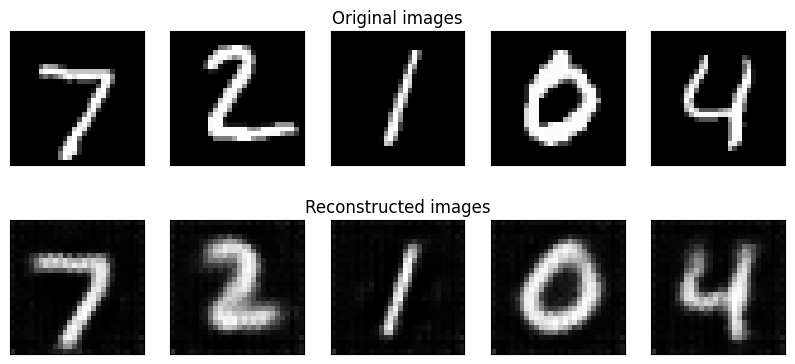

\t partial train loss (single batch): 0.033447
\t partial train loss (single batch): 0.031773
\t partial train loss (single batch): 0.030699
\t partial train loss (single batch): 0.029684
\t partial train loss (single batch): 0.032114
\t partial train loss (single batch): 0.030972
\t partial train loss (single batch): 0.031498
\t partial train loss (single batch): 0.031045
\t partial train loss (single batch): 0.031133
\t partial train loss (single batch): 0.030997
\t partial train loss (single batch): 0.031007
\t partial train loss (single batch): 0.032457
\t partial train loss (single batch): 0.032882
\t partial train loss (single batch): 0.033526
\t partial train loss (single batch): 0.030498
\t partial train loss (single batch): 0.032231
\t partial train loss (single batch): 0.031746
\t partial train loss (single batch): 0.031454
\t partial train loss (single batch): 0.032648
\t partial train loss (single batch): 0.032943
\t partial train loss (single batch): 0.032093
\t partial tr

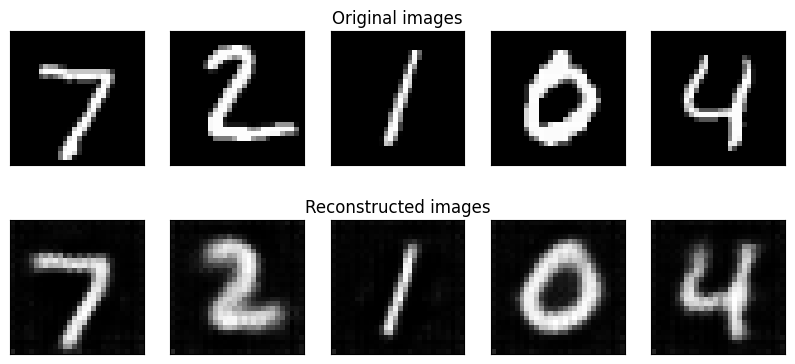

\t partial train loss (single batch): 0.032295
\t partial train loss (single batch): 0.030692
\t partial train loss (single batch): 0.029368
\t partial train loss (single batch): 0.028347
\t partial train loss (single batch): 0.030925
\t partial train loss (single batch): 0.029636
\t partial train loss (single batch): 0.030037
\t partial train loss (single batch): 0.029832
\t partial train loss (single batch): 0.029749
\t partial train loss (single batch): 0.029691
\t partial train loss (single batch): 0.029577
\t partial train loss (single batch): 0.031142
\t partial train loss (single batch): 0.031645
\t partial train loss (single batch): 0.032172
\t partial train loss (single batch): 0.029231
\t partial train loss (single batch): 0.030864
\t partial train loss (single batch): 0.030482
\t partial train loss (single batch): 0.030160
\t partial train loss (single batch): 0.031280
\t partial train loss (single batch): 0.031512
\t partial train loss (single batch): 0.030794
\t partial tr

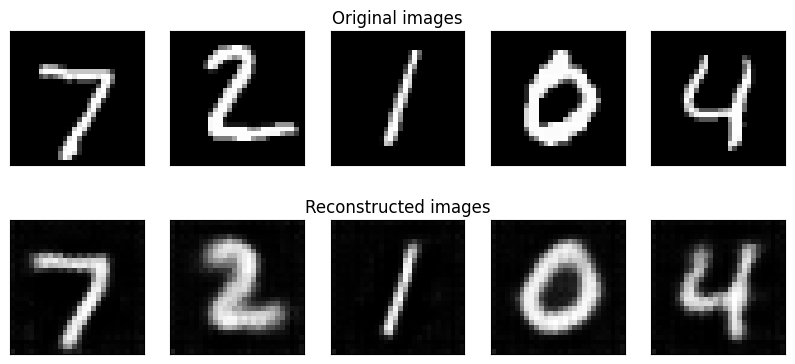

\t partial train loss (single batch): 0.031499
\t partial train loss (single batch): 0.030025
\t partial train loss (single batch): 0.028517
\t partial train loss (single batch): 0.027676
\t partial train loss (single batch): 0.030166
\t partial train loss (single batch): 0.028786
\t partial train loss (single batch): 0.029082
\t partial train loss (single batch): 0.029059
\t partial train loss (single batch): 0.028801
\t partial train loss (single batch): 0.028905
\t partial train loss (single batch): 0.028648
\t partial train loss (single batch): 0.030339
\t partial train loss (single batch): 0.030857
\t partial train loss (single batch): 0.031393
\t partial train loss (single batch): 0.028530
\t partial train loss (single batch): 0.030053
\t partial train loss (single batch): 0.029613
\t partial train loss (single batch): 0.029452
\t partial train loss (single batch): 0.030369
\t partial train loss (single batch): 0.030740
\t partial train loss (single batch): 0.030045
\t partial tr

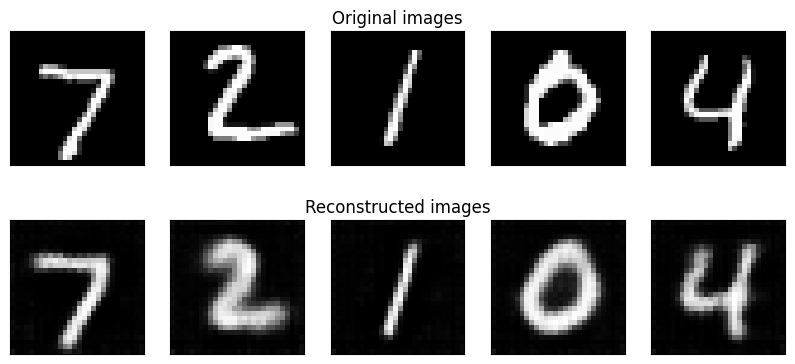

\t partial train loss (single batch): 0.030881
\t partial train loss (single batch): 0.029572
\t partial train loss (single batch): 0.027969
\t partial train loss (single batch): 0.027235
\t partial train loss (single batch): 0.029766
\t partial train loss (single batch): 0.028179
\t partial train loss (single batch): 0.028481
\t partial train loss (single batch): 0.028518
\t partial train loss (single batch): 0.028102
\t partial train loss (single batch): 0.028427
\t partial train loss (single batch): 0.027992
\t partial train loss (single batch): 0.029793
\t partial train loss (single batch): 0.030298
\t partial train loss (single batch): 0.030848
\t partial train loss (single batch): 0.027970
\t partial train loss (single batch): 0.029545
\t partial train loss (single batch): 0.029055
\t partial train loss (single batch): 0.028954
\t partial train loss (single batch): 0.029836
\t partial train loss (single batch): 0.030109
\t partial train loss (single batch): 0.029416
\t partial tr

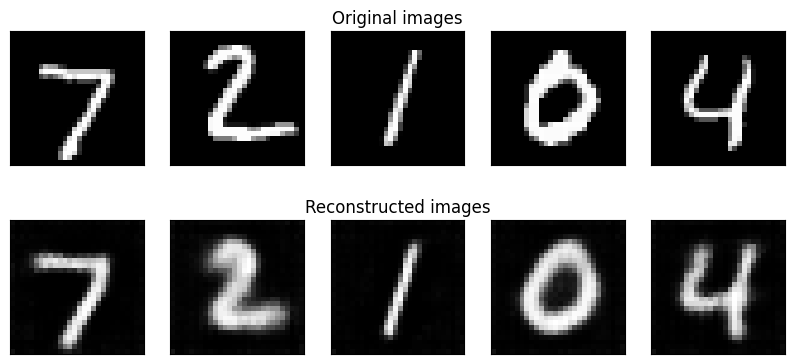

\t partial train loss (single batch): 0.030380
\t partial train loss (single batch): 0.029084
\t partial train loss (single batch): 0.027745
\t partial train loss (single batch): 0.026767
\t partial train loss (single batch): 0.029392
\t partial train loss (single batch): 0.027686
\t partial train loss (single batch): 0.027943
\t partial train loss (single batch): 0.028052
\t partial train loss (single batch): 0.027564
\t partial train loss (single batch): 0.028030
\t partial train loss (single batch): 0.027567
\t partial train loss (single batch): 0.029360
\t partial train loss (single batch): 0.029838
\t partial train loss (single batch): 0.030422
\t partial train loss (single batch): 0.027558
\t partial train loss (single batch): 0.028996
\t partial train loss (single batch): 0.028654
\t partial train loss (single batch): 0.028501
\t partial train loss (single batch): 0.029297
\t partial train loss (single batch): 0.029671
\t partial train loss (single batch): 0.028932
\t partial tr

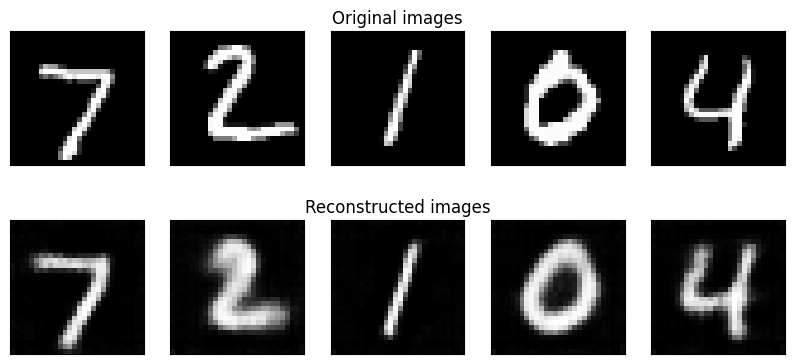

\t partial train loss (single batch): 0.029990
\t partial train loss (single batch): 0.028625
\t partial train loss (single batch): 0.027443
\t partial train loss (single batch): 0.026388
\t partial train loss (single batch): 0.029055
\t partial train loss (single batch): 0.027326
\t partial train loss (single batch): 0.027540
\t partial train loss (single batch): 0.027825
\t partial train loss (single batch): 0.027076
\t partial train loss (single batch): 0.027568
\t partial train loss (single batch): 0.027215
\t partial train loss (single batch): 0.028977
\t partial train loss (single batch): 0.029410
\t partial train loss (single batch): 0.030073
\t partial train loss (single batch): 0.027169
\t partial train loss (single batch): 0.028533
\t partial train loss (single batch): 0.028305
\t partial train loss (single batch): 0.028145
\t partial train loss (single batch): 0.028890
\t partial train loss (single batch): 0.029302
\t partial train loss (single batch): 0.028534
\t partial tr

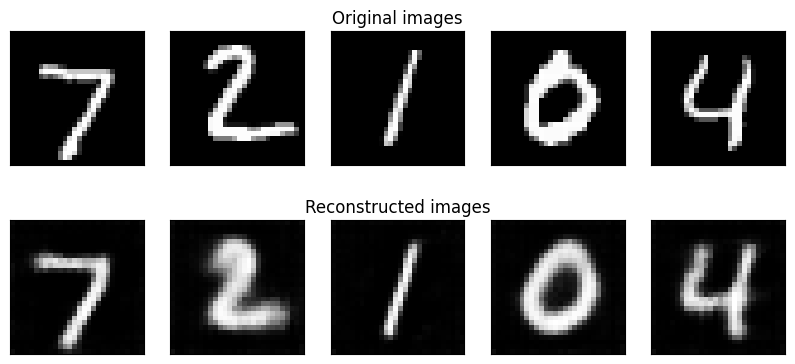

In [30]:
num_epochs = 10
history={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    train_loss = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
    val_loss = test_epoch(encoder,decoder,device,valid_loader,loss_fn)

    print('\\n EPOCH {}/{} \\t train loss {:.3f} \\t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    plot_ae_outputs(encoder,decoder,n=5)

In [31]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.028185131028294563

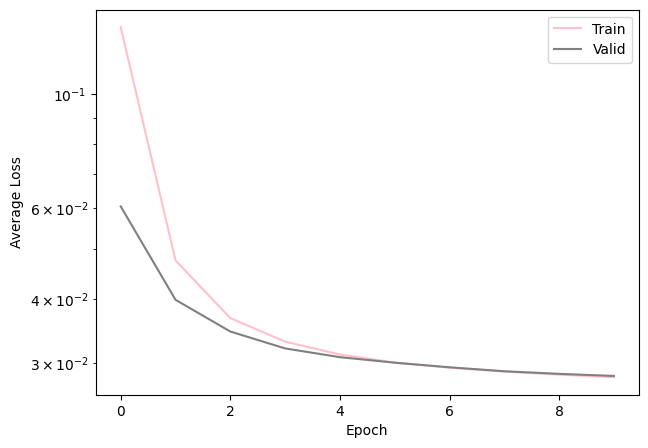

In [32]:
# Тренувальна та валідаційна втрати
plt.figure(figsize=(7,5))
plt.semilogy(history['train_loss'], label='Train', color='pink')
plt.semilogy(history['val_loss'], label='Valid', color='gray')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

**Висновок:** У ході виконання лабораторної роботи було розроблено автокодувальник для розпізнавання зображень рукописних цифр з доданим гаусовим шумом. За допомогою бібліотеки PyTorch побудовано модель автокодувальника, що складається з енкодера та декодера, яка навчалася відновлювати чисте зображення на основі зашумленого вхідного сигналу.

Модель успішно навчалася на модифікованому датасеті MNIST, до якого було додано шум, що дозволило перевірити її здатність до реконструкції зображень. У процесі навчання проводився контроль втрати (loss), яка поступово зменшувалася протягом епох, що підтверджує ефективність навчання. Візуалізація результатів (noisy → denoised → original) продемонструвала, що автокодувальник добре відновлює вхідні дані, зберігаючи основні риси цифр.

Отже, дана модель може бути використана як базовий інструмент для передобробки зображень у задачах комп’ютерного зору, де дані мають часткові спотворення або шум.